In [22]:
# Cell 1: Imports, double precision, and device
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pickle, time

torch.set_default_dtype(torch.float64)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [23]:
# Cell 2: Big, deep NN
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 100), nn.Tanh(),
            nn.Linear(100, 100), nn.Tanh(),
            nn.Linear(100, 100), nn.Tanh(),
            nn.Linear(100, 100), nn.Tanh(),
            nn.Linear(100, 1)
        )
    def forward(self, x):
        return self.layers(x)
model = Net().to(device)
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)
model.apply(init_weights)


Net(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Tanh()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): Tanh()
    (6): Linear(in_features=100, out_features=100, bias=True)
    (7): Tanh()
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [24]:
# def exact_solution(x):
#     # x: [N,2]
#     # u(x1, x2) = x1^2 * x2^2 * (1 - x1)^2 * (1 - x2)^2
#     return x[:,0]**2 * x[:,1]**2 * (1 - x[:,0])**2 * (1 - x[:,1])**2

# def rhs_f(x):
#     x.requires_grad_()
#     u = exact_solution(x)

#     # 1. First Laplacian (Delta u)
#     grad_u = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
#     lap_u = sum([
#         torch.autograd.grad(grad_u[:, i], x, torch.ones_like(grad_u[:, i]), create_graph=True)[0][:, i]
#         for i in range(2)
#     ])

#     # 2. Second Laplacian (Delta^2 u) - Apply same logic to lap_u
#     grad_lap = torch.autograd.grad(lap_u, x, torch.ones_like(lap_u), create_graph=True)[0]
#     biharmonic = sum([
#         torch.autograd.grad(grad_lap[:, i], x, torch.ones_like(grad_lap[:, i]), create_graph=True)[0][:, i]
#         for i in range(2)
#     ])

#     return biharmonic.detach() # Detach because f is a constant constant ground truth
# def dirichlet_bc(x):  # Dirichlet on all boundaries
#     return exact_solution(x)
def exact_solution(x):
    # x: (N, 2)
    x1 = x[:, 0]
    x2 = x[:, 1]
    # Example 3.2: u(x) = x1^2 (1-x1)^2 x2^2 (1-x2)^2
    u = x1**2 * (1 - x1)**2 * x2**2 * (1 - x2)**2
    return u.unsqueeze(-1)

def rhs_f(x):
    # f = Δ^2 u (biharmonic of exact solution)
    x = x.clone().detach().requires_grad_(True)
    u = exact_solution(x)

    # grad u
    grad_u = torch.autograd.grad(
        u, x, torch.ones_like(u), create_graph=True
    )[0]

    # Laplacian Δu
    lap_u = 0.0
    for i in range(2):
        grad_ui = torch.autograd.grad(
            grad_u[:, i], x, torch.ones_like(grad_u[:, i]),
            create_graph=True
        )[0][:, i]
        lap_u = lap_u + grad_ui

    # Biharmonic Δ^2 u
    grad_lap = torch.autograd.grad(
        lap_u, x, torch.ones_like(lap_u), create_graph=True
    )[0]
    biharmonic = 0.0
    for i in range(2):
        grad_lap_i = torch.autograd.grad(
            grad_lap[:, i], x, torch.ones_like(grad_lap[:, i]),
            create_graph=True
        )[0][:, i]
        biharmonic = biharmonic + grad_lap_i

    return biharmonic.detach()

def dirichlet_bc(x):
    # g1 = u on the boundary
    return exact_solution(x)


In [25]:
def exact_g2(x, n):
    """
    g2 = ∂_n(Δu) on boundary.
    x: (M, 2), n: (M, 2)
    """
    x = x.clone().detach().requires_grad_(True)
    u = exact_solution(x)

    # grad u
    grad_u = torch.autograd.grad(
        u, x, torch.ones_like(u), create_graph=True
    )[0]

    # Laplacian Δu
    lap_u = 0.0
    for i in range(2):
        grad_ui = torch.autograd.grad(
            grad_u[:, i], x, torch.ones_like(grad_u[:, i]),
            create_graph=True
        )[0][:, i]
        lap_u = lap_u + grad_ui

    # grad(Δu)
    grad_lap = torch.autograd.grad(
        lap_u, x, torch.ones_like(lap_u), create_graph=True
    )[0]

    # normal derivative ∂_n(Δu)
    g2 = (grad_lap * n).sum(dim=1)
    return g2.detach()


In [26]:
# Cell 4: Boundary sampler with normals
N_int, N_bd = 11000, 5000

def get_interior(N):
    return torch.rand(N, 2, device=device)

def get_boundary(M):
    grid = torch.linspace(0, 1, M//4, device=device)
    zeros = torch.zeros_like(grid)
    ones = torch.ones_like(grid)

    # Points on the 4 sides
    pts = [
        torch.stack([grid, zeros], dim=1), # Bottom (y=0)
        torch.stack([grid, ones], dim=1),  # Top (y=1)
        torch.stack([zeros, grid], dim=1), # Left (x=0)
        torch.stack([ones, grid], dim=1)   # Right (x=1)
    ]

    # Corresponding Normal vectors
    normals = [
        torch.stack([zeros, -ones], dim=1), # Bottom normal (0, -1)
        torch.stack([zeros, ones], dim=1),  # Top normal (0, 1)
        torch.stack([-ones, zeros], dim=1), # Left normal (-1, 0)
        torch.stack([ones, zeros], dim=1)   # Right normal (1, 0)
    ]

    return torch.cat(pts, dim=0), torch.cat(normals, dim=0)

In [ ]:
# Cell 5: DRM Loss with Neumann-type BC (P2)
def drm_loss(model, x_int, x_bd, n_bd, bc_weight=1000.0):
    # --- 1. Interior: biharmonic energy ---
    x_int = x_int.clone().detach().requires_grad_(True)
    u_int = model(x_int)  # (N_int, 1)

    # grad u
    grad_u = torch.autograd.grad(
        u_int, x_int, torch.ones_like(u_int), create_graph=True
    )[0]

    # Laplacian Δu
    lap_u = 0.0
    for i in range(2):
        grad_ui = torch.autograd.grad(
            grad_u[:, i], x_int, torch.ones_like(grad_u[:, i]),
            create_graph=True
        )[0][:, i]
        lap_u = lap_u + grad_ui

    f = rhs_f(x_int)  # (N_int, 1)
    energy = 0.5 * (lap_u**2).mean() - (f.squeeze() * u_int.squeeze()).mean()

    # --- 2. Boundary: Dirichlet + Neumann-type (∂_nu) ---
    x_bd = x_bd.clone().detach().requires_grad_(True)
    u_bd = model(x_bd).squeeze(-1)

    # Dirichlet term: u - g1
    g1 = dirichlet_bc(x_bd).squeeze(-1)
    bc_dir = (u_bd - g1).pow(2).mean()

    # Neumann term: ∂_n(u) - g2
    grad_u_bd = torch.autograd.grad(
        u_bd, x_bd, torch.ones_like(u_bd), create_graph=True
    )[0]

    # lap_u_bd = 0.0
    # for i in range(2):
    #    grad_ui_bd = torch.autograd.grad(
    #        grad_u_bd[:, i], x_bd, torch.ones_like(grad_u_bd[:, i]),
    #        create_graph=True
    #    )[0][:, i]
    #    lap_u_bd = lap_u_bd + grad_ui_bd

    # grad_lap_bd = torch.autograd.grad(
    #    lap_u_bd, x_bd, torch.ones_like(lap_u_bd), create_graph=True
    # )[0]
    dnd_lap_pred = (grad_u_bd * n_bd).sum(dim=1)

    g2 = exact_g2(x_bd, n_bd)
    bc_neu = (dnd_lap_pred - g2).pow(2).mean()

    return energy + bc_weight * (bc_dir + bc_neu)

In [28]:
# Cell 6: Training
epochs = 20000
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=700, gamma=0.3)
losses = []
start_time = time.time()

for epoch in range(epochs):
    # Unpack normals here
    x_int, (x_bd, n_bd) = get_interior(N_int), get_boundary(N_bd)

    # Pass normals to loss
    if epoch <= 4000:
      bc_w = 5.0
    elif epoch <= 10000:
      bc_w = 100.0
    elif epoch <= 15000:
      bc_w = 500.0
    else:
      bc_w = 1000.0
    loss = drm_loss(model, x_int, x_bd, n_bd, bc_weight=bc_w)

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.5)
    optimizer.step()
    scheduler.step()
    losses.append(loss.item())

    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Loss {loss.item():.6e}, LR: {scheduler.optimizer.param_groups[0]['lr']:.2e}")

# Final LBFGS
lbfgs = torch.optim.LBFGS(model.parameters(), lr=0.5, max_iter=1000)
def closure():
    x_int, (x_bd, n_bd) = get_interior(N_int), get_boundary(N_bd)
    loss = drm_loss(model, x_int, x_bd, n_bd, bc_weight=5000.0)
    lbfgs.zero_grad()
    loss.backward()
    return loss
lbfgs.step(closure)
train_time = time.time() - start_time

Epoch 0: Loss 1.086844e+00, LR: 5.00e-03
Epoch 500: Loss -1.213065e-01, LR: 5.00e-03
Epoch 1000: Loss -1.315582e-01, LR: 1.50e-03
Epoch 1500: Loss -1.312683e-01, LR: 4.50e-04
Epoch 2000: Loss -1.339572e-01, LR: 4.50e-04
Epoch 2500: Loss -1.325360e-01, LR: 1.35e-04
Epoch 3000: Loss -1.334679e-01, LR: 4.05e-05
Epoch 3500: Loss -1.327690e-01, LR: 1.22e-05
Epoch 4000: Loss -1.351647e-01, LR: 1.22e-05
Epoch 4500: Loss -3.718953e-05, LR: 3.64e-06
Epoch 5000: Loss -3.074496e-04, LR: 1.09e-06
Epoch 5500: Loss -3.314619e-05, LR: 1.09e-06
Epoch 6000: Loss -2.521378e-04, LR: 3.28e-07
Epoch 6500: Loss -1.938942e-04, LR: 9.84e-08
Epoch 7000: Loss -2.956346e-04, LR: 2.95e-08
Epoch 7500: Loss -5.025315e-04, LR: 2.95e-08
Epoch 8000: Loss -3.303444e-04, LR: 8.86e-09
Epoch 8500: Loss -4.628744e-04, LR: 2.66e-09
Epoch 9000: Loss -3.681264e-04, LR: 2.66e-09
Epoch 9500: Loss -3.073566e-04, LR: 7.97e-10
Epoch 10000: Loss -4.818605e-04, LR: 2.39e-10
Epoch 10500: Loss 6.771297e-02, LR: 7.17e-11
Epoch 11000: L

In [29]:
# Cell 7: Save outputa
torch.save(model.state_dict(), "drm_model_q2.pt")

In [30]:
# Cell 8: Print arch/settings
print(f"Training time: {train_time:.2f} s")
print("NN Architecture:\n", model)
n_L = sum(torch.count_nonzero(p).item() for p in model.parameters())
print("Total nonzero parameters n_L:", n_L)
print("Adam lr: 5e-4, LBFGS steps: 1000")
print("Interior pts:", N_int, "Boundary pts:", N_bd, "Boundary penalty: Variable")
print(f"Final training loss: {losses[-1]:.6e}")


Training time: 4746.87 s
NN Architecture:
 Net(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Tanh()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): Tanh()
    (6): Linear(in_features=100, out_features=100, bias=True)
    (7): Tanh()
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)
Total nonzero parameters n_L: 30701
Adam lr: 5e-4, LBFGS steps: 1000
Interior pts: 11000 Boundary pts: 5000 Boundary penalty: Variable
Final training loss: 1.520944e-01


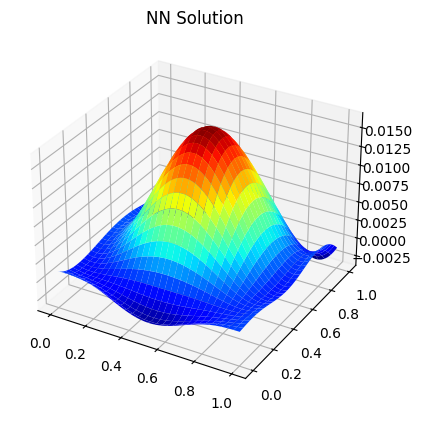

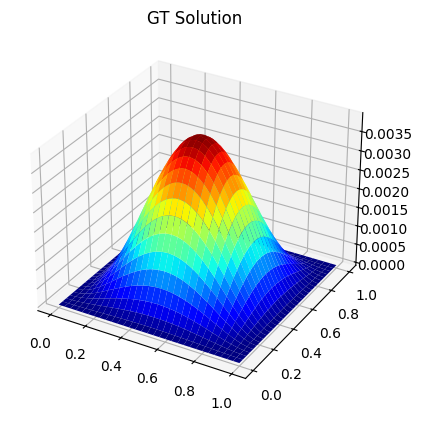

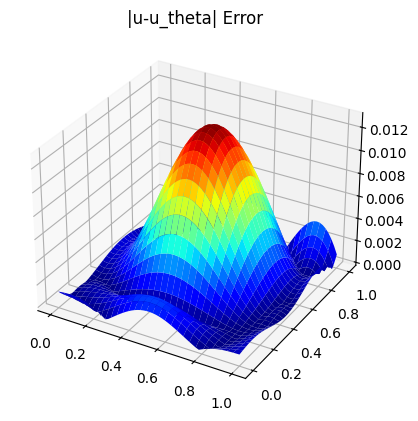

In [31]:
# Cell 9: Plot solution/error
gsize = 61
xg = np.linspace(0, 1, gsize)
mg = np.meshgrid(xg, xg)
gp = torch.tensor(np.stack([mg[0].ravel(), mg[1].ravel()], axis=-1), device=device, dtype=torch.float64)

with torch.no_grad():
    u_nn = model(gp).detach().cpu().numpy().reshape(gsize, gsize)
    u_gt = exact_solution(gp).detach().cpu().numpy().reshape(gsize, gsize)
    err = np.abs(u_nn - u_gt)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(mg[0], mg[1], u_nn, cmap='jet')
plt.title('NN Solution')
plt.savefig("NNsolution2.png")
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(mg[0], mg[1], u_gt, cmap='jet')
plt.title('GT Solution')
plt.savefig("GTsol2.png")
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(mg[0], mg[1], err, cmap='jet')
plt.title('|u-u_theta| Error')
plt.savefig("Error2.png")
plt.show()


In [32]:
## Cell 10: Error calculation (careful detaching!)
gp.requires_grad_()
u_gt1d = exact_solution(gp).detach().cpu().numpy()
u_nn1d = model(gp).detach().cpu().numpy()

u_gt_val = exact_solution(gp)
u_nn_val = model(gp)
u_gt_grad = torch.autograd.grad(u_gt_val, gp, torch.ones_like(u_gt_val), create_graph=True)[0]
u_nn_grad = torch.autograd.grad(u_nn_val, gp, torch.ones_like(u_nn_val), create_graph=True)[0]
u_gt_grad_np = u_gt_grad.detach().cpu().numpy()
u_nn_grad_np = u_nn_grad.detach().cpu().numpy()
H_gt = [torch.autograd.grad(u_gt_grad[:, i], gp, torch.ones_like(u_gt_grad[:, i]), create_graph=True)[0][:, i].detach().cpu().numpy() for i in range(2)]
H_nn = [torch.autograd.grad(u_nn_grad[:, i], gp, torch.ones_like(u_nn_grad[:, i]), create_graph=True)[0][:, i].detach().cpu().numpy() for i in range(2)]
def H2norm(H): return np.sqrt(sum([np.mean(h**2) for h in H]))
def H1norm(grad): return np.sqrt(np.mean(grad[:,0]**2 + grad[:,1]**2))

L2Err = np.sqrt(np.mean((u_gt1d-u_nn1d)**2))
RelL2Err = L2Err / np.sqrt(np.mean(u_gt1d**2))
energyErr = L2Err + H1norm(u_gt_grad_np-u_nn_grad_np)
relEnergyErr = energyErr / (np.sqrt(np.mean(u_gt1d**2)) + H1norm(u_gt_grad_np))
H2Err = H2norm([H_gt[0]-H_nn[0], H_gt[1]-H_nn[1]])
relH2Err = H2Err / H2norm(H_gt)

print(f"L2 Error: {L2Err:.3e}")
print(f"Relative L2 Error: {RelL2Err:.3e}")
print(f"Energy Error (L2 + H1): {energyErr:.3e}")
print(f"Relative Energy Error (H1Relative): {relEnergyErr:.3e}")
print(f"H2 Error: {H2Err:.3e}")
print(f"Relative H2 Error: {relH2Err:.3e}")


L2 Error: 4.926e-03
Relative L2 Error: 3.155e+00
Energy Error (L2 + H1): 3.333e-02
Relative Energy Error (H1Relative): 3.619e+00
H2 Error: 2.153e-01
Relative H2 Error: 4.167e+00


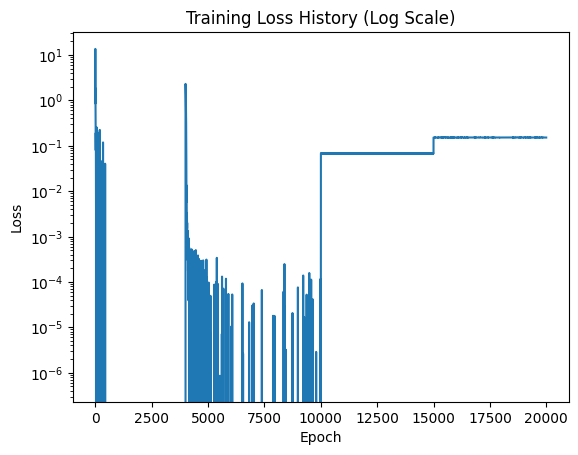

In [33]:
plt.figure()
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale('log')  # <- THIS is the key change!
plt.title("Training Loss History (Log Scale)")
plt.savefig("LossHistory_log_2.png")
plt.show()